## 1. Module Import, Select Device, and Download MNIST Data

### 1-1. Setup & Module Import

In [ ]:
!pip install pennylane pennylane-ionq qiskit[visualization]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from pennylane_ionq import ops
import matplotlib.pyplot as plt

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.random import random_circuit

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

### 1-2. Select Device

In [ ]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    DEVICE = torch.device('cuda')
    print('cuda index:', torch.cuda.current_device())
    print('GPU:', torch.cuda.get_device_name())
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.9.0+cu102  Device: cpu


### 1-3. Setting of the main hyper-parameters of the model

In [ ]:
BATCH_SIZE = 16
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 128    # Size of the train dataset
n_test = 32     # Size of the test dataset

SAVE_PATH = "quanvolution_pqc/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
seed = 47
np.random.seed(seed)        # Seed for NumPy random number generator
torch.manual_seed(seed)     # Seed for TensorFlow random number generator

os.environ['IONQ_API_KEY']='1LCa7Dvzz5P35g6B3gwoxzFO04n7gWYH'   # IonQ Token
#dev = qml.device("ionq.qpu", wires=9)
dev = qml.device("default.qubit", wires=9)

### 1-4. Data Loading

In [ ]:
from torch.utils.data import SubsetRandomSampler
train_dataset = datasets.MNIST(root = "./mnist_data",
                               train = True,
                               download = True,
                               transform = transforms.Compose([
                                               transforms.Resize(size=14),
                                               transforms.ToTensor()]))

test_dataset = datasets.MNIST(root = "./mnist_data",
                              train = False,
                              transform = transforms.Compose([
                                              transforms.Resize(size=14),
                                              transforms.ToTensor()]))

# train_dataset = Subset(train_dataset,range(n_train))
# test_dataset = Subset(test_dataset,range(n_test))

train_sampler = SubsetRandomSampler(range(n_train))
test_sampler = SubsetRandomSampler(range(n_test))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          sampler = test_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 14, 14]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


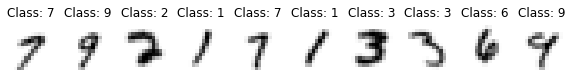

In [ ]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(14, 14), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

## 2. Construct Quantum Circuit

### 2-1. Create a 'Quantum Class' with Qiskit

In [ ]:
# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params,circuit_type):
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
                      
    if circuit_type == 2:     # len(params) == 18
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CNOT(wires=[i,i-1])    
    elif circuit_type == 3:   # len(params) == 26
        # PQC
        for i in range(n_qubits):
            qml.RX(params[i], wires=i)
        for i in range(n_qubits):
            qml.RX(params[i+n_qubits], wires=i)
        for k,i in enumerate(range(n_qubits-1,0,-1)):
            qml.CRZ(params[k+2*n_qubits], wires=[i,i-1])
    elif circuit_type == 9:   # len(params) == 9
        # PQC
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
        for i in range(n_qubits):
            qml.RX(params[i],wires=i)
    elif circuit_type == 10:  # len(params) == 18
        for i in range(n_qubits):
            qml.RY(params[i],wires=i)
        for i in range(n_qubits-1,0,-1):
            qml.CZ(wires=[i,i-1])
            qml.CZ(wires=[0,n_qubits-1])
        for i in range(n_qubits):
            qml.RY(params[i+n_qubits],wires=i)
    elif circuit_type == 'random':
        # Random quantum circuit
        rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, n_qubits))
        RandomLayers(rand_params, wires=list(range(4)))
    else:
        print("Invalid circuit_type")
        raise NotImplementedError
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

In [ ]:
print(pqc(torch.tensor([1,0,2,1,2,3,1,2,0]),torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]), 'random'))

tensor(0.5221, dtype=torch.float64)


In [12]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True,opt=True,circuit_type=9):
        super().__init__()
        self.qc = qc
        self.opt = opt
        self.n_qubits = 9
        self.filters = 1
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3,padding='same')
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        self.fc1 = torch.nn.Linear(200,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        if circuit_type == 2:
          self.num_q_params = 2*self.n_qubits
        elif circuit_type == 3:
          self.num_q_params = 3*self.n_qubits - 1
        elif circuit_type == 9:
          self.num_q_params = self.n_qubits
        elif circuit_type == 10:
          self.num_q_params = 2*self.n_qubits
        if use_cuda:
            self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(self.filters,self.num_q_params).cuda()).to('cuda')
        else:
            self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(self.filters,self.num_q_params))
        self.q_params.requires_grad = True
        if self.qc:
          self.circuit_type = circuit_type
        else:
          self.circno = 0

    def forward(self, inputs):
        if self.qc == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12)).cuda()
          for bat, image in enumerate(inputs):
              if use_cuda:
                  image = image.cuda()
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      for i in range(self.filters):
                          window = image[0, j-1:j+2, k-1:k+2].squeeze()
                          window_flatten = window.reshape(n_qubits)
                          q_results = pqc(
                              window_flatten,
                              self.q_params[i],
                              circno=self.circno
                          )
                          out[bat,i,j - 1, k - 1] = F.relu(q_results.cuda())
        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if self.opt==True:
          out = F.relu(self.conv_opt(inputs))
        # print("out", out.type)
        x = self.pool(F.relu(self.conv1(out)))
        # print("x", x.type)
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x.cuda()

In [ ]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=False,opt=True)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=0.01)
summary(model,(1,28,28))

In [ ]:
for p in model.parameters():
    print(p.shape)

In [ ]:
losses = []
accs = []
for epoch in range(10000):
  train_loss = 0
  acc = 0
  for (x_train, y_train) in train_loader:
    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  if epoch%10 == 9:
    if epoch%100 == 99:
      print(epoch+1,train_loss)
    losses.append(train_loss.item())
  if epoch%10 == 9:
    accs.append(acc) 
  del acc

In [ ]:
from matplotlib.pyplot import plot
x = np.arange(0,10000,10)
plot(x,losses)

In [ ]:
x = np.arange(0,10000,10)
plot(x,accs)

In [ ]:
file = pd.DataFrame(data={'train_loss': losses,
                          'train_acc': accs})
file.to_pickle(file_name)